In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

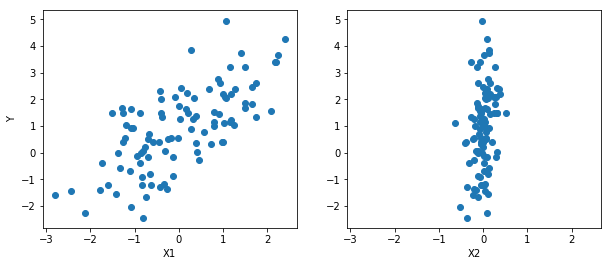

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [5]:
from pymc3 import Model, Normal, HalfNormal

In [6]:
#入れ物
basic_model = Model()

#pymc3ではwith instanceの書き方以外ではエラーを吐く
#Normalで正規分布
#HalfNormalで生の値しかとらない、半分の正規分布

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [7]:
help(Normal) #try help(Model), help(Uniform) or help(basic_model)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean.
 |  sd : float
 |      Standard deviation (sd > 0).
 |  tau : float
 |      Precision (tau > 0).
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distr

In [8]:
#MAP推定
from pymc3 import find_MAP
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21
{'alpha': array(0.9065985497559482), 'beta': array([ 0.94848602,  2.60705514]), 'sigma_log_': array(-0.03278147017403074)}


In [9]:
from scipy import optimize
# pymc3 be defaults apply Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior 
# but also allows selection of other optimization algorithms from the scipy.optimize module.
#下の例だとPowell methodを使っている

map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176
{'alpha': array(0.9090521898978398), 'beta': array([ 0.95140146,  2.61437458]), 'sigma_log_': array(-0.03000977520318259)}


In [10]:
from pymc3 import NUTS, sample
from scipy import optimize
# step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis
with basic_model:
    # draw 2000 posterior samples
    trace = sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -153.48: 100%|██████████| 200000/200000 [00:17<00:00, 11169.98it/s]
Finished [100%]: Average ELBO = -153.51
100%|██████████| 2000/2000 [00:03<00:00, 569.29it/s]


In [11]:
trace['alpha'][-5:]

array([ 0.82666567,  0.98027484,  0.98443864,  0.98443864,  0.92134001])

In [12]:
from pymc3 import Slice

with basic_model: 
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = Slice(vars=[sigma])

    # draw 5000 posterior samples
    trace = sample(5000, step=step, start=start)

Assigned NUTS to alpha
Assigned NUTS to beta


Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


100%|██████████| 5000/5000 [00:06<00:00, 825.72it/s] 


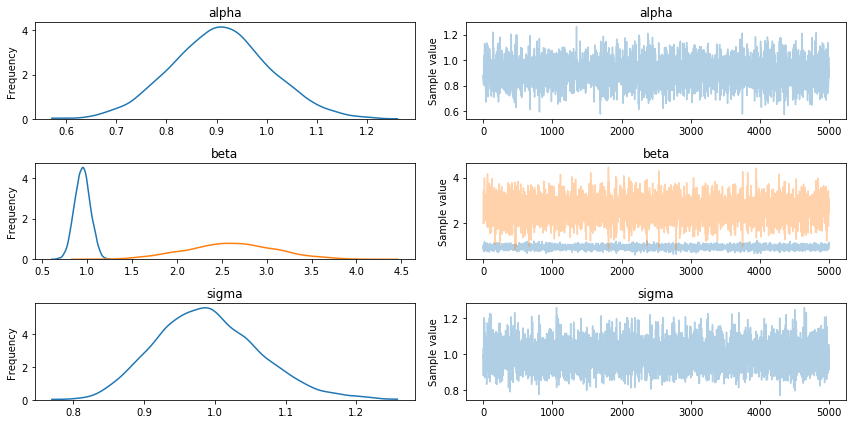

In [13]:
from pymc3 import traceplot

traceplot(trace);

In [14]:
from pymc3 import summary

summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.907            0.098            0.001            [0.705, 1.093]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.713          0.841          0.906          0.971          1.105


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.087            0.001            [0.776, 1.111]
  2.606            0.504            0.007            [1.664, 3.644]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.781          0.889          0.948          1.006          1.118
  1.626          2.273          2.604   

In [15]:
try:
    from pandas_datareader import data
except ImportError:
    !pip install pandas-datareader
    from pandas_datareader import data

    100% |████████████████████████████████| 71kB 2.5MB/s ta 0:00:01
  Using cached requests_file-1.4.1-py2.py3-none-any.whl
  Running setup.py bdist_wheel for requests-ftp ... - \ done
  Stored in directory: /Users/01017387/Library/Caches/pip/wheels/76/fb/0d/1026eb562c34a4982dc9d39c9c582a734eefe7f0455f711deb
Successfully built requests-ftp


In [16]:
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

print(len(returns))

401


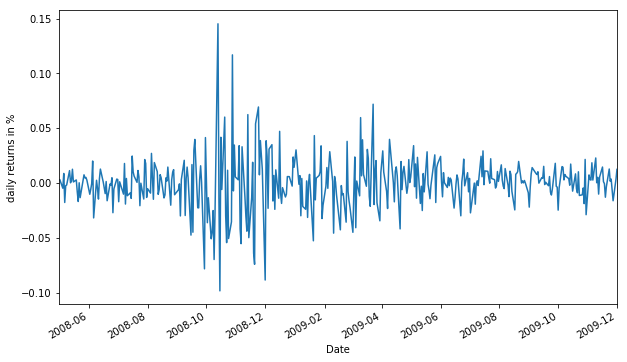

In [17]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [18]:
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as sp500_model:

    nu = Exponential('nu', 1./10, testval=5.)

    sigma = Exponential('sigma', 1./.02, testval=.1)

    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))

    volatility_process = Deterministic('volatility_process', exp(-2*s))

    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

In [19]:
from pymc3 import variational

import scipy
with sp500_model:
    trace = sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.34: 100%|██████████| 200000/200000 [00:39<00:00, 5107.17it/s]
Finished [100%]: Average ELBO = 883.27
100%|██████████| 2000/2000 [03:42<00:00,  9.00it/s]


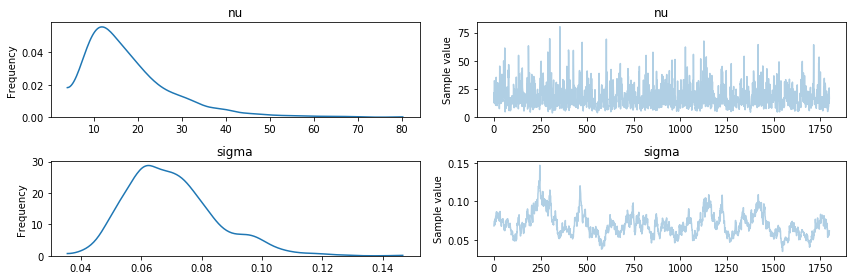

In [20]:
traceplot(trace[200:], [nu, sigma]);

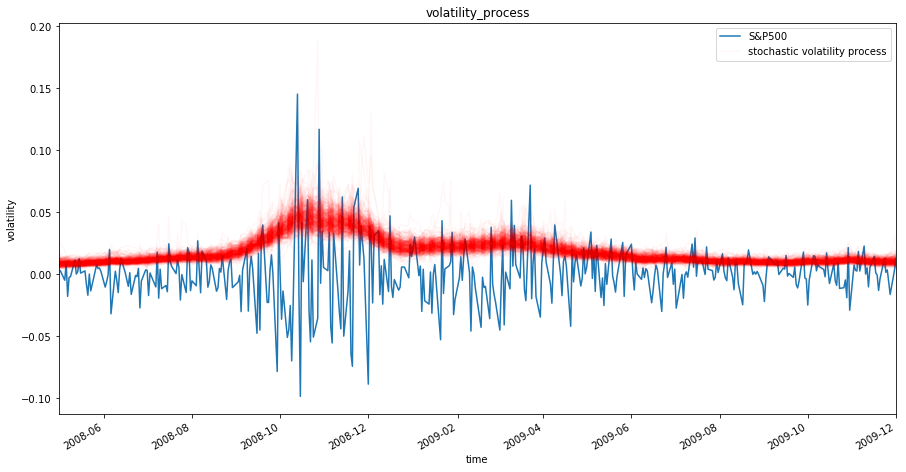

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])